In [1189]:
import numpy as np
import pandas as pd
import rwi

from sklearn.decomposition import PCA


from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
%matplotlib inline

In [1190]:
import rwi
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [1191]:
def load_df(name):
    eurusd_df = pd.read_csv(name)
    eurusd_df = eurusd_df.rename(columns={'<TICKER>':'Ticker', '<DTYYYYMMDD>':'Date', '<TIME>':'Time', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'})
    eurusd_df[['Date']] = pd.to_datetime(eurusd_df['Date'].astype('str'), yearfirst=True)
    eurusd_df =eurusd_df.sort_values(by=['Date', 'Time'])
    eur_df = eurusd_df[['Date', 'Time', 'Close', 'Open', 'High', 'Low', 'Vol']].rename(columns={'Close':'Close'})
    eur_df['Change'] = eur_df['Close'].pct_change()
    eur_df.dropna(inplace=True)
    #eur_df = eur_df[eur_df.Date>'2020-01-01']
    #eur_df = eur_df.set_index('Date')
    return eur_df

In [1192]:
import FinanceDataReader as fdr

In [1193]:
#sp500 = fdr.DataReader('US500', start = '2009-01-01')

In [1194]:
#sp500.to_csv('SP500.csv', encoding='utf-8')

In [1242]:
sp500 = pd.read_csv('SP500.csv', encoding='utf-8')
sp500['Date'] = pd.to_datetime(sp500['Date'], yearfirst=True)
sp500 = sp500.set_index('Date')
#sp500 = sp500.loc[:'2019-12-31']
sp500['price'] = sp500['Close']

In [1243]:
sp500 = rwi.generate_features(sp500)

In [1244]:
sp500['atr_5'] = sp500.returns.rolling(5).std()
sp500['atr_20'] = sp500.returns.rolling(20).std()
sp500['atr_50'] = sp500.returns.rolling(50).std()
sp500['atr_200'] = sp500.returns.rolling(200).std()

sp500['range'] = 100*(sp500['High'] - sp500['Low'])/sp500['Low']
sp500['adj_close'] = sp500['Close'] / (sp500['High']*0.5 + sp500['Low']*0.5)
sp500['adj_close'] = sp500['adj_close'].replace([np.inf, -np.inf, 0], 0)

sp500['month'] = sp500.index.month
sp500['day'] = sp500.index.day
sp500['week_day'] = sp500.index.dayofweek


In [1245]:
#sp500 = pd.get_dummies(sp500, columns=['month', 'day', 'week_day'])

In [1246]:
sp500.loc[:,'shift_returns'] = sp500['ROC_20'].shift(-20)

sp500.dropna(inplace=True)

In [1247]:

sp500 = sp500[sp500.shift_returns != 0.0]


In [1248]:
sp500.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'price', 'returns',
       'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50', 'ROC_100', 'ROC_200',
       'ROC_500', 'abs_returns', 'atr_5', 'atr_20', 'atr_50', 'atr_200',
       'range', 'adj_close', 'month', 'day', 'week_day', 'shift_returns'],
      dtype='object')

In [1249]:
sp500.drop(columns=['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'price', 'returns',
       'ROC_2', 'ROC_3', 'ROC_5', 'atr_5', 'abs_returns',   'range', 'adj_close'], inplace=True)

In [1229]:
sp500.drop(columns=['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'price', 
         'range', 'adj_close'], inplace=True)

In [1250]:

X = sp500.drop(columns='shift_returns')
y = sp500['shift_returns']

In [1251]:


y = np.sign(y)

X = X.select_dtypes('number')


In [1275]:
X_train=X.iloc[:int(X.shape[0] * 0.75)]
y_train = y[:int(X.shape[0] * 0.75)]
X_test = X.iloc[int(X.shape[0] * 0.80):]
y_test = y[int(X.shape[0] * 0.80):]
#X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=0.20, random_state=42)

In [1276]:
X.shape[0] * 0.80 - X.shape[0] * 0.75

115.45000000000005

In [1277]:
clf = RandomForestClassifier(n_estimators= 1000, random_state=0, criterion='gini', n_jobs=-1)


In [1278]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [1279]:
y_pred = clf.predict(X_test)

In [1280]:
score = clf.score(X_test, y_test)

In [1281]:
from sklearn.metrics import roc_auc_score
rf_probs = clf.predict_proba(X_test)[:, 1]
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

In [1282]:
# we have to reove low tf indicators
print(score, roc_value)

0.5454545454545454 0.47178206145335255


In [1287]:
pd.DataFrame(clf.feature_importances_, index=X.columns).sort_values(by=[0], ascending=False)

,0
atr_200,0.155687
atr_50,0.122495
atr_20,0.116230
ROC_500,0.109498
ROC_200,0.100643
ROC_100,0.094260
ROC_50,0.085335
ROC_20,0.080791
month,0.080227
day,0.042152


In [1289]:
X_test['shift_returns'] = sp500.loc[X_test.index]['shift_returns']
X_test['pred'] = y_pred
X_test['direction'] = np.sign(X_test.shift_returns)
X_test['res'] = X_test.shift_returns  * X_test['pred']

C:\Users\lexik\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\lexik\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lexik\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

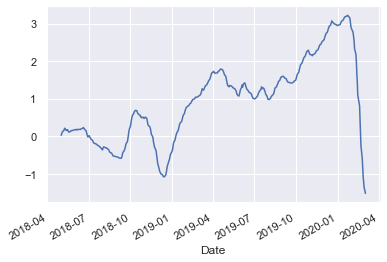

In [1292]:
# 10h
(X_test.res.cumsum()).plot()

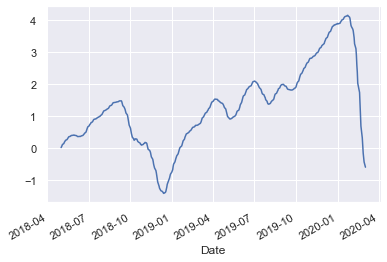

In [1293]:
X_test.shift_returns.cumsum().plot()

In [1296]:
def apply_pca(X_):
    
    pca = PCA(n_components=3,  random_state=40)

    pca_X = pca.fit_transform(X_.fillna(0)) 

    #print(pca.explained_variance_ratio_)

    #print(pca.singular_values_)
    pca_X = pd.DataFrame(pca_X, columns=['p1', 'p2', 'p3'])
    return pca_X

In [1332]:
cols = ['ROC_20',  'atr_20', 'ROC_50', 'atr_50']
pca_X = apply_pca(X_train[cols])
kmeans = KMeans(6, random_state=40).fit(pca_X)
pca_X = apply_pca(X_test[cols])
clusters = kmeans.predict(pca_X)
X_test.loc[:,'clusters'] = clusters

C:\Users\lexik\.conda\envs\NN\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


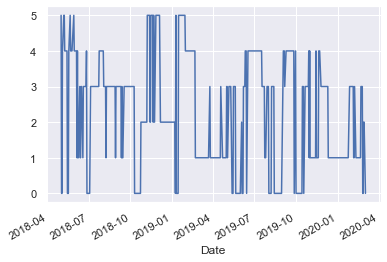

In [1333]:
X_test.clusters.plot()

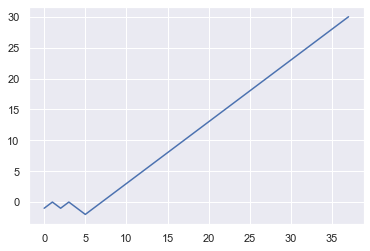

In [1334]:
X_test[X_test.clusters==2].reset_index().pred.cumsum().plot()

In [1326]:
X_test['res_bin'] = np.sign(X_test.res)

C:\Users\lexik\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1348]:
X_test[X_test.clusters==1].groupby(X_test.res_bin).count()

,ROC_20,ROC_50,ROC_100,ROC_200,ROC_500,atr_20,atr_50,atr_200,month,day,week_day,shift_returns,pred,direction,res,clusters,res_bin
res_bin,,,,,,,,,,,,,,,,,
-1.0,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
1.0,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72


In [1349]:
# 0 
72 / (72+42)

0.631578947368421